# scPRINT use case on BPH

In this use-case, also presented in Figure 5 of our [manuscript](https://www.biorxiv.org/content/10.1101/2024.07.29.605556v1), we perform an extensive analysis of a multi studies dataset of benign prostatic hyperplasia. 

Our biological question is to check if there exist pre-cancerous cells that exhibits behaviors of mature cancer cells at this early stage of the disease. 

In those cells, we  want to know which genes might be implicated in cell state changes, and explore  potentially novel targets in the treatment of prostate cancer and BPH.

We will start with a fresh datasets coming from the [cellXgene database](https://cellxgene.cziscience.com/) and representing [2 studies of BPH](https://pathsocjournals.onlinelibrary.wiley.com/doi/10.1002/path.5751).

We will first explore these dataset to understand:

- what are the cell types that are present in the data
- what are the cell distributions (cell distributions? what are they?)
- what sequencers were used, etc.

We also want to confirm existing target in prostate cancer through precancerous lesion analysis, and find potentially novel ones that would serve as less invasive BPH treatments than current ones.

Finally we  want to know how these targets interacts and are involved in biological pathways.

We now showcase how to use scPRINT across its different functionalities to answer some of these questions.

## table of contents:

1. [Downloading and preprocessing](#downloading-and-preprocessing)
2. [Embedding and annotations](#embedding-and-annotations)
3. [Annotation cleanup](#annotation-cleanup)
4. [Clustering and differential expression](#clustering-and-differential-expression)
5. [Denoising and differential expression](#denoising-and-differential-expression)
6. [Gene network inference](#gene-network-inference)

> In the notebook [cancer_usecase_part2.ipynb](./cancer_usecase_part2.ipynb) you will see how to analyse cell type specific gene regulatory networks.



In [1]:
from scprint import scPrint
from scdataloader import Preprocessor, utils
from scprint.tasks import GNInfer, Embedder, Denoiser, withknn

from bengrn import BenGRN, get_sroy_gt, compute_genie3
from bengrn.base import train_classifier

from grnndata import utils as grnutils
from grnndata import read_h5ad

from anndata.utils import make_index_unique
from anndata import concat
import scanpy as sc

from matplotlib import pyplot as plt
import numpy as np
import lamindb as ln

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

💡 connected lamindb: jkobject/scprint


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:53: DeprecationWarning: jax.core.Shape is deprecated. Use Shape = Sequence[int | Any].
  Shape = jax.core.Shape
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:54: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  PRNGKey = jax.random.KeyArray
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_types.py:9: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.i

## Downloading and preprocessing

We now use [lamindb](https://lamin.ai/) to easily access cellxgene and download a dataset of normal and benign prostatic hyperplasia tissues.

data is available here https://cellxgene.cziscience.com/e/574e9f9e-f8b4-41ef-bf19-89a9964fd9c7.cxg/ .

We then use scDataloader's preprocessing method. This method is quite extensive and does a few things.. find our more about it [on its documentation](https://www.jkobject.com/scDataLoader/).

On our end we are using the preprocessor to make sure that the the gene expression that we have are raw counts and that we have enough information to use scPRINT (i.e., enough genes expressed and enough counts per cells across the dataset). 
 
Finally, the preprocessor will also increase the size of the expression matrix to be a fixed set of genes defined by the latest version of ensemble.

In [2]:
cx_dataset = ln.Collection.using(instance="laminlabs/cellxgene").filter(name="cellxgene-census", version='2023-12-15').one()

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/asyncio/sslproto.py:320: ResourceWarning: unclosed transport <asyncio.sslproto._SSLProtocolTransport object at 0x7fd088b36f80>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)


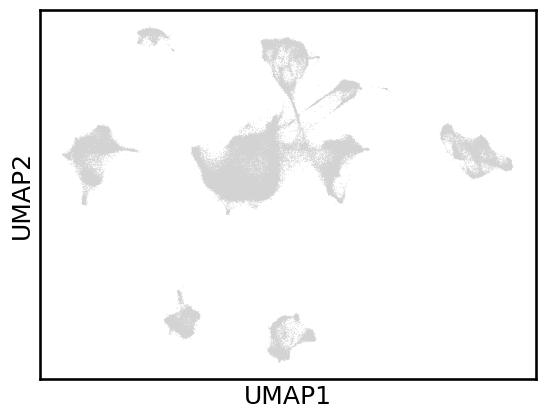

In [3]:
prostate_adata = cx_dataset.artifacts.filter(key='cell-census/2023-12-15/h5ads/574e9f9e-f8b4-41ef-bf19-89a9964fd9c7.h5ad').one().load()
sc.pl.umap(prostate_adata)

In [7]:
# preprocessing using scDataloader
prostate_adata.obs.drop(columns="is_primary_data", inplace=True)
preprocessor = Preprocessor(do_postp=False)
prostate_adata = preprocessor(prostate_adata)

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 83451 renamining
filtered out 0 cells, 83451 renamining
Removed 76 genes.
validating


/home/ml4ig1/Documents code/scPRINT/scDataLoader/scdataloader/preprocess.py:241: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_utils.validate(adata, organism=adata.obs.organism_ontology_term_id[0])


startin QC

Seeing 13047 outliers (15.63% of total dataset):
done


## Embedding and annotations

We now start to load a large version of scPRINT from a specific checkpoint. Please [download](https://huggingface.co/jkobject/scPRINT/tree/main) the checkpoints following the instructions in the README.

We will then use out Embedder class to embed the data and annotate the cells. These classes are how we parametrize and access the different functions of `scPRINT`. Find out more about its parameters in our [documentation](https://www.jkobject.com/scPrint/).



In [6]:
model = scPrint.load_from_checkpoint('../data/temp/o2uniqsx/epoch=18-step=133000.ckpt', 
    # make sure that you check if you have a GPU with flashattention or not (see README)
    # you need this else, the model will look for the file with the embeddings instead of getting them from the weights
    precpt_gene_emb = None)


RuntimeError caught: scPrint is not attached to a `Trainer`.



In [10]:
embedder = Embedder( 
                    # can work on random genes or most variables etc..
                    how="random expr", 
                    # number of genes to use
                    max_len=4000, 
                    add_zero_genes=0, 
                    # for the dataloading
                    num_workers=8, 
                    # we will only use the cell type embedding here.
                    pred_embedding = ["cell_type_ontology_term_id"]
                    )#, "disease_ontology_term_id"])

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


100%|██████████| 1560/1560 [28:20<00:00,  1.09s/it]


AnnData object with n_obs × n_vars = 99826 × 424
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in panda

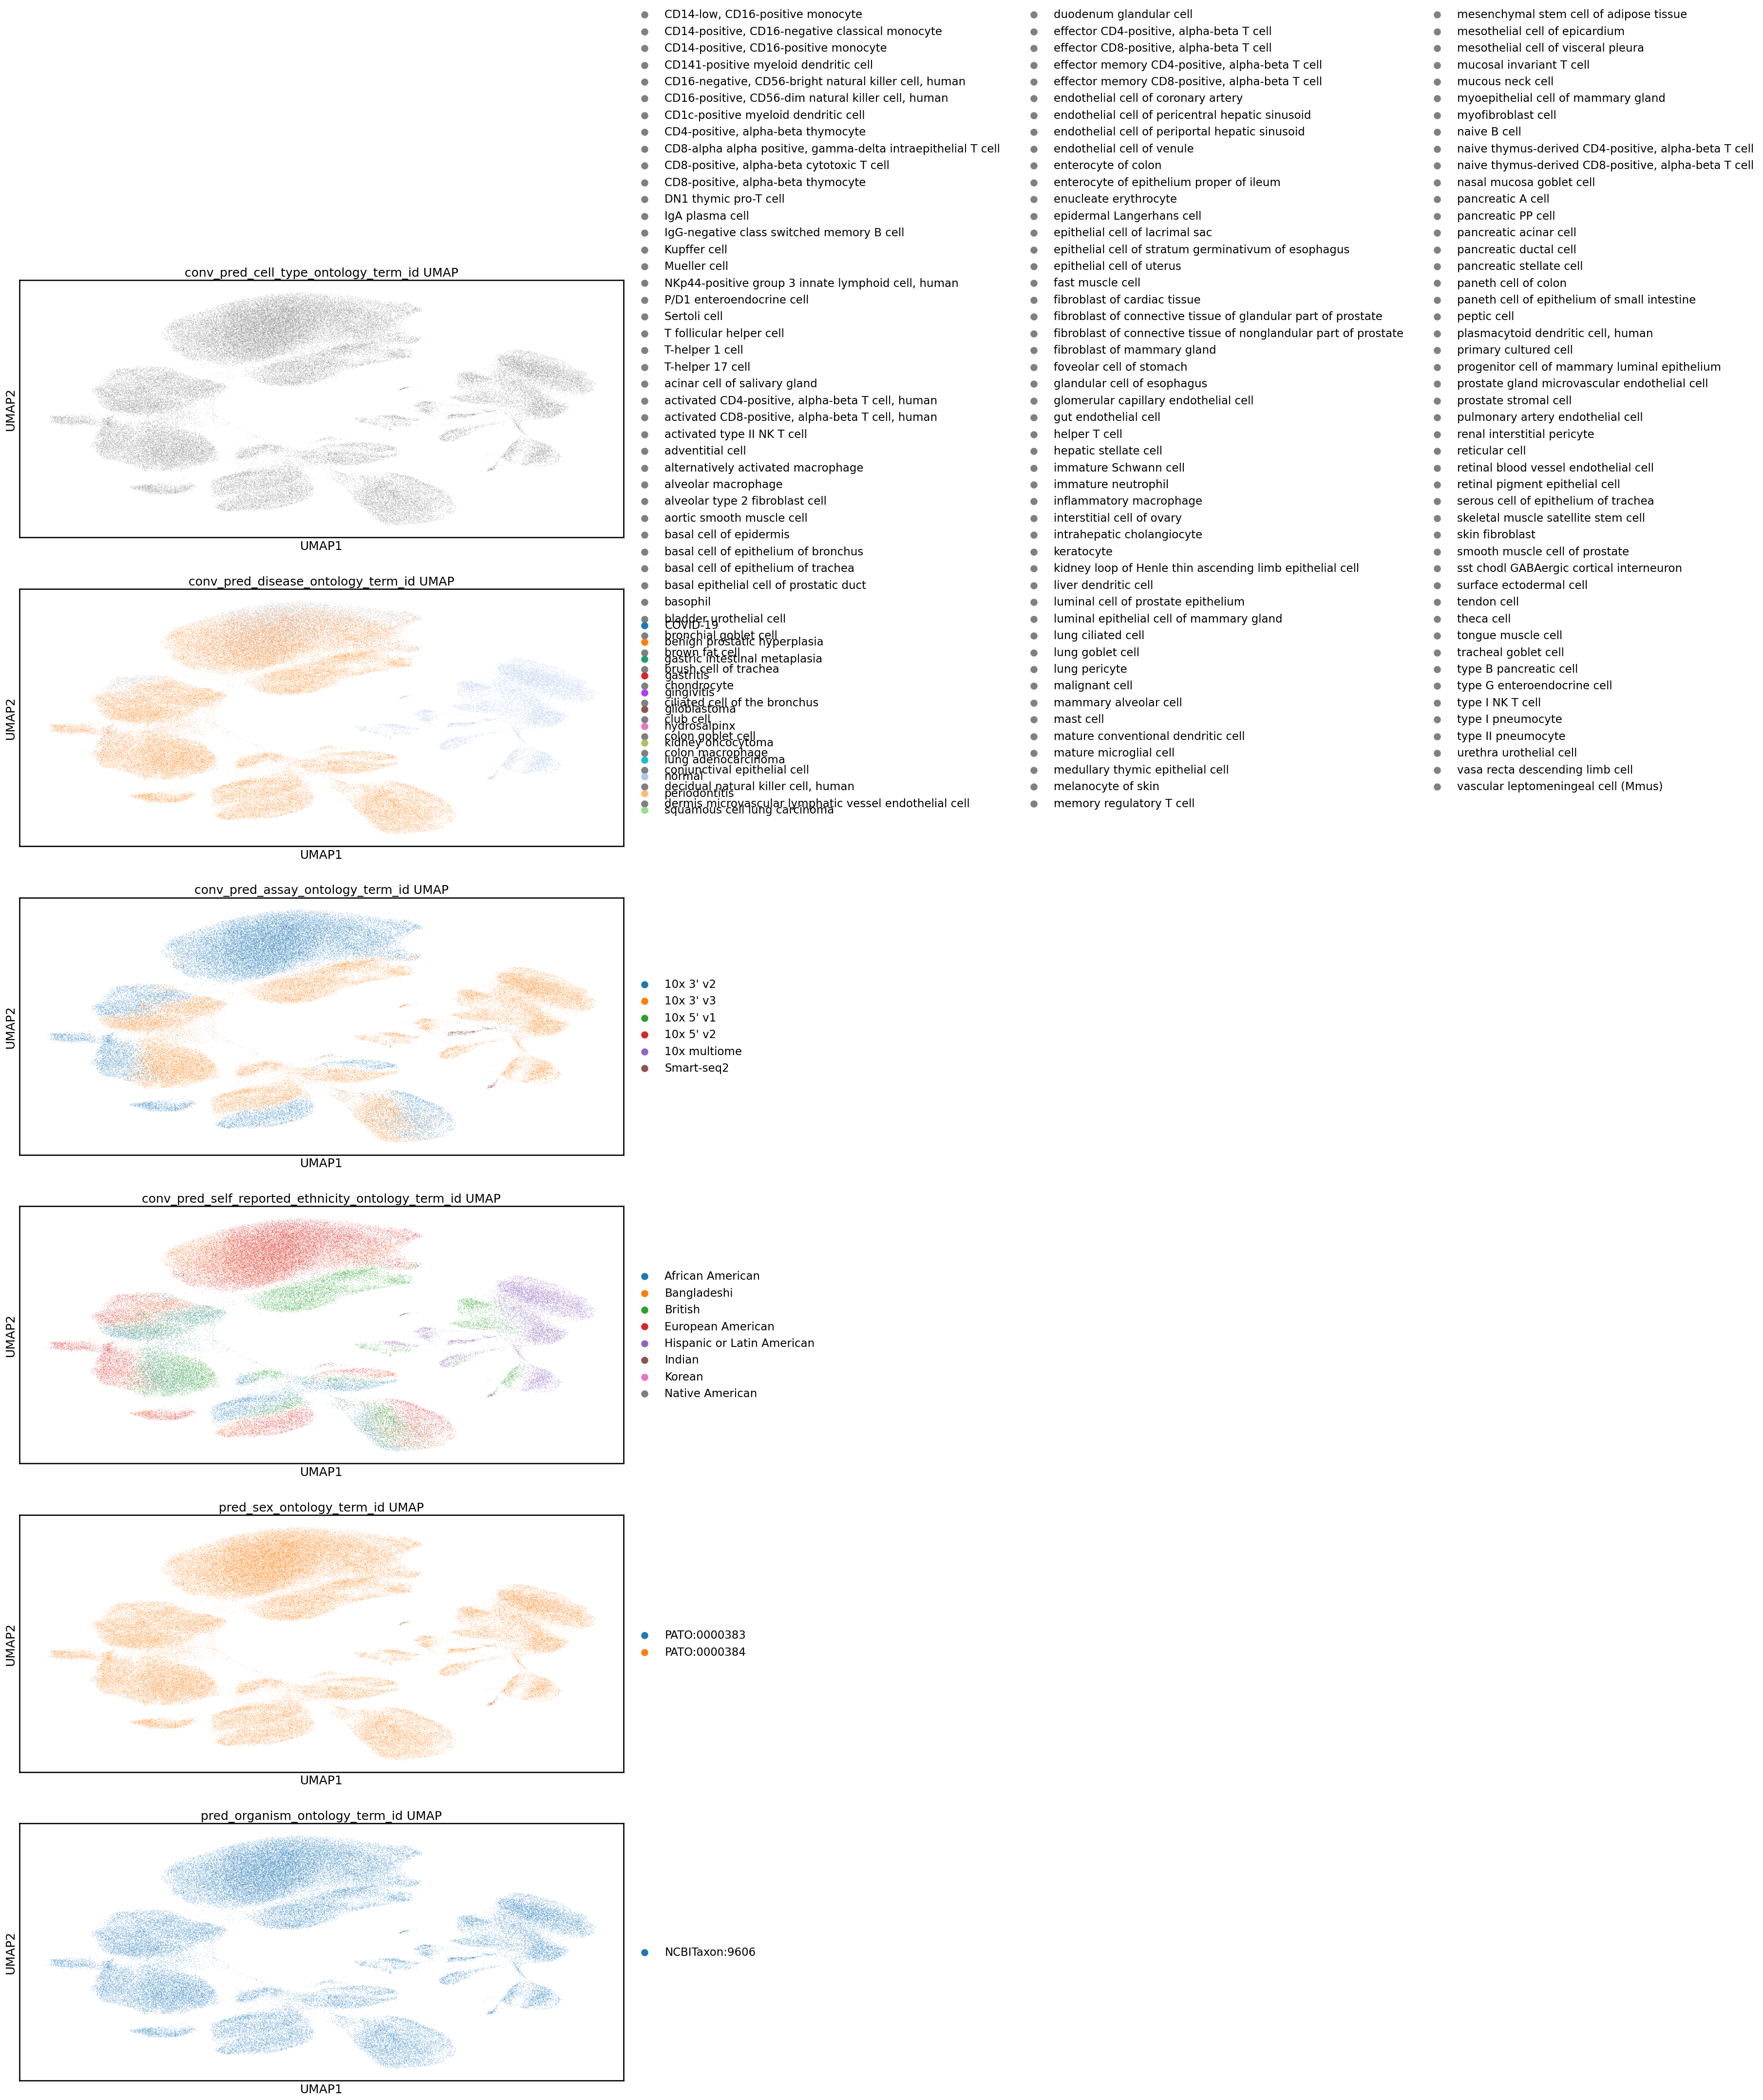

couldn't log to tensorboard
couldn't log to wandb

couldn't log to wandb
     cell_type_ontology_term_id
     accuracy: 0.7250215374752068
 
     disease_ontology_term_id
     accuracy: 0.8394506441207702
 
     assay_ontology_term_id
     accuracy: 0.998988239536794
 
     self_reported_ethnicity_ontology_term_id
     accuracy: 0.9504037024422495
 
     sex_ontology_term_id
     accuracy: 0.9948911105323263
 
     organism_ontology_term_id
     accuracy: 1.0
 


In [ ]:
# create the embedding
prostate_adata, metrics = embedder(model, prostate_adata, cache=False, output_expression="none")

In [16]:
prostate_adata

AnnData object with n_obs × n_vars = 99826 × 70116
    obs: 'assay_ontology_term_id', 'donor_id', 'sex_ontology_term_id', 'disease_ontology_term_id', 'organism_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'init_dataset', 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology

## Annotation cleanup

scPRINT generates predictions over hundreds of possible labels for each cell. 

It is often advised to "cleanup" the predictions, e.g. making sure to remove low frequency cells and misslabellings. 

Here, we use the most straightforward approach which is to remove any annotations that appear a small number of times.

A better approach would be doing majority voting over cell clusters as it would aggregate and smoothout the predictions over multiple cells. it would also remove most of the low frequency mistakes in the predictions.

We will also have a look at the embeddings of `scPRINT` by plotting its UMAP visualization.


<Axes: ylabel='count'>

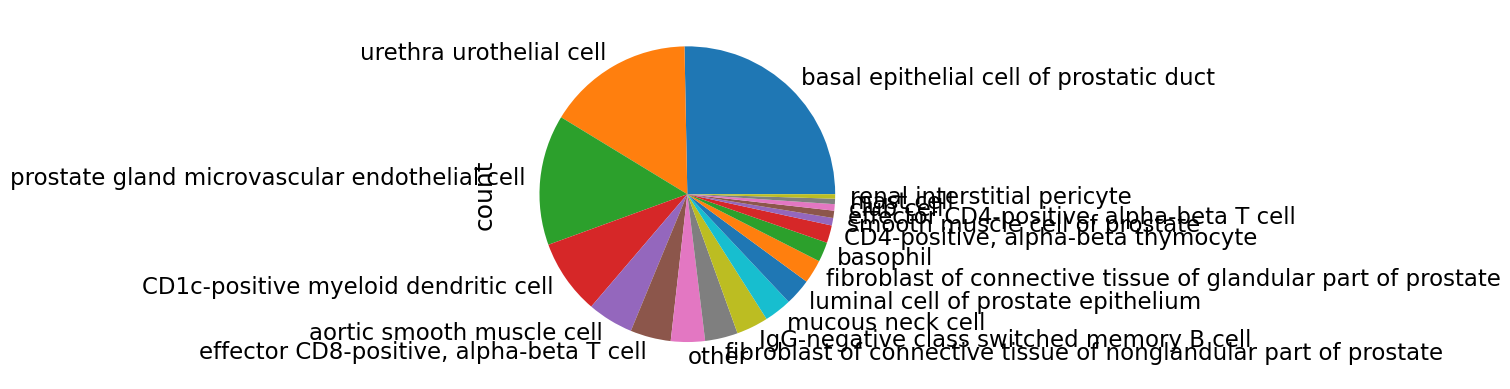

In [30]:
#cleaning up the cell types
prostate_adata.obs['cleaned_pred_cell_type_ontology_term_id'] = prostate_adata.obs['conv_pred_cell_type_ontology_term_id'].astype(str)
prostate_adata.obs.loc[~prostate_adata.obs['conv_pred_cell_type_ontology_term_id'].isin([k for k, v in prostate_adata.obs['conv_pred_cell_type_ontology_term_id'].value_counts().items() if v > 400]), 'cleaned_pred_cell_type_ontology_term_id'] = "other"
prostate_adata.obs['cleaned_pred_cell_type_ontology_term_id'].value_counts().plot.pie()

<Axes: ylabel='count'>

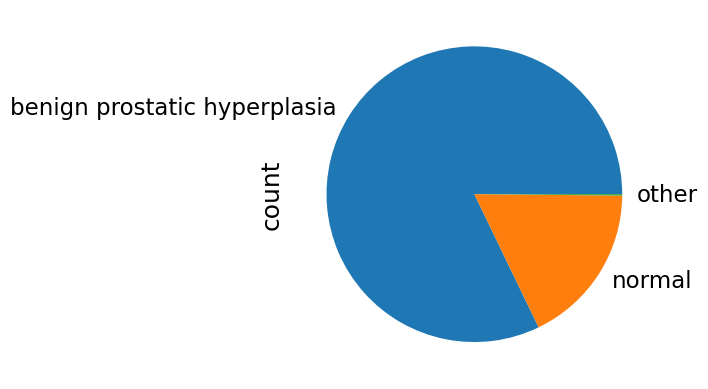

In [31]:
# cleaning up the diseases
prostate_adata.obs['cleaned_pred_disease_ontology_term_id'] = prostate_adata.obs['conv_pred_disease_ontology_term_id'].astype(str)
prostate_adata.obs.loc[~prostate_adata.obs['conv_pred_disease_ontology_term_id'].isin([k for k, v in prostate_adata.obs['conv_pred_disease_ontology_term_id'].value_counts().items() if v > 1000]), 'cleaned_pred_disease_ontology_term_id'] = "other"
prostate_adata.obs['cleaned_pred_disease_ontology_term_id'].value_counts().plot.pie()

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


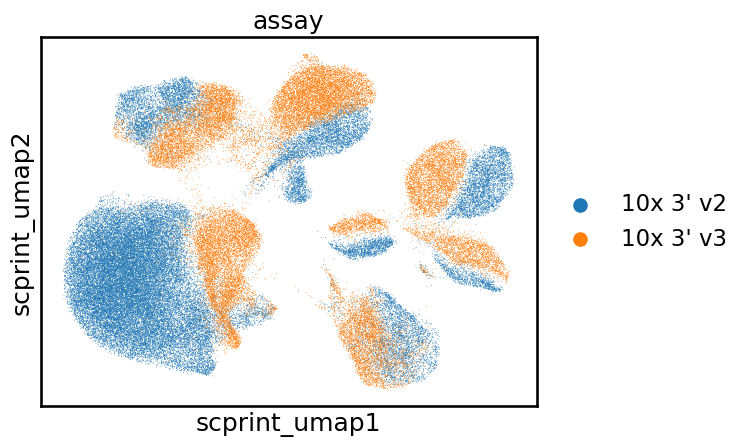

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


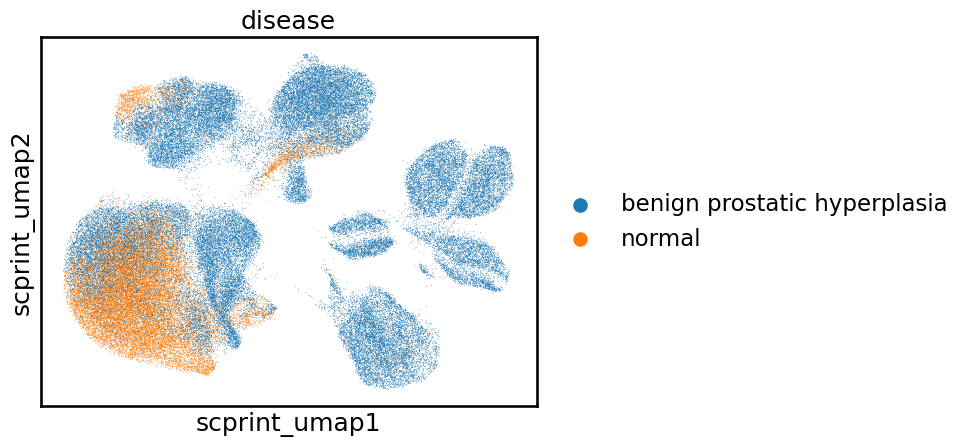

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


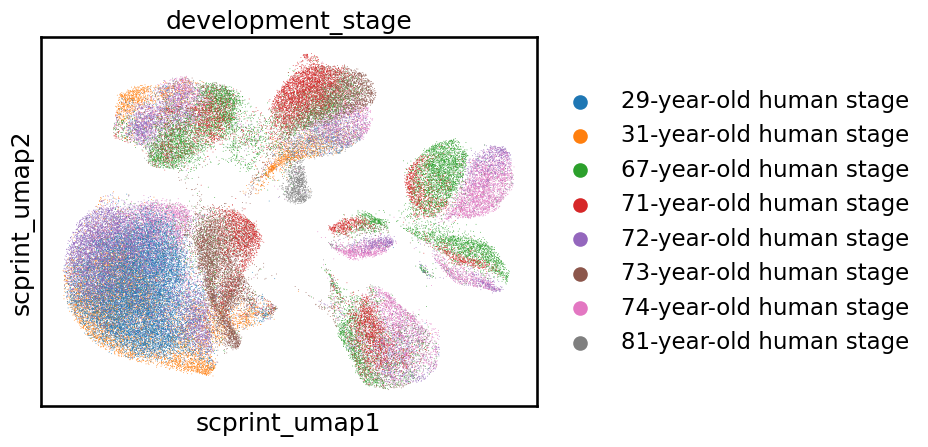

In [38]:
sc.pl.embedding(prostate_adata, basis="scprint_umap", color=['cleaned_pred_cell_type_ontology_term_id'])
sc.pl.embedding(prostate_adata, basis="scprint_umap", color=['cleaned_pred_disease_ontology_term_id'])
sc.pl.embedding(prostate_adata, basis="scprint_umap", color=['assay'])
sc.pl.embedding(prostate_adata, basis="scprint_umap", color=['disease'])
sc.pl.embedding(prostate_adata, basis="scprint_umap", color=['development_stage'])

In [ ]:
prostate_adata.obs.cleaned_pred_cell_type_ontology_term_id.value_counts().head(20)

cleaned_pred_cell_type_ontology_term_id
basal cell of epidermis                                             22449
mammary alveolar cell                                                9688
vasa recta descending limb cell                                      8777
CD1c-positive myeloid dendritic cell                                 5782
effector memory CD8-positive, alpha-beta T cell                      5410
smooth muscle cell of the pulmonary artery                           5007
other                                                                4972
pancreatic acinar cell                                               4639
basal epithelial cell of prostatic duct                              3405
serous cell of epithelium of trachea                                 3327
prostate gland microvascular endothelial cell                        2747
paneth cell of epithelium of small intestine                         2698
mast cell                                                            236

In [39]:
# we save for next time
prostate_adata.write_h5ad("../../data/prostate_adata_o2uniqsx.h5ad")

In [2]:
prostate_adata = sc.read_h5ad("../../data/prostate_adata_o2uniqsx.h5ad")

## Clustering and differential expression

We will now cluster using the louvain algorithm on a kNN graph. 

Once we detect a cluster of interest we will perform differential expression analysis on it. Taking as example some B-cell clusters, we will use scanpy's implementation of rank_gene_groups for our differential expression

In [15]:
# do louvain mutliple times
sc.pp.neighbors(prostate_adata, n_neighbors=10, use_rep="scprint")
# using multiple resolutions can help spotting smaller clusters
sc.tl.louvain(prostate_adata, resolution=0.5, key_added="louvain_0.5")
sc.tl.louvain(prostate_adata, resolution=1.0, key_added="louvain_1.0")

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


<Axes: title={'center': 'louvain_1.0'}, xlabel='scprint_umap1', ylabel='scprint_umap2'>

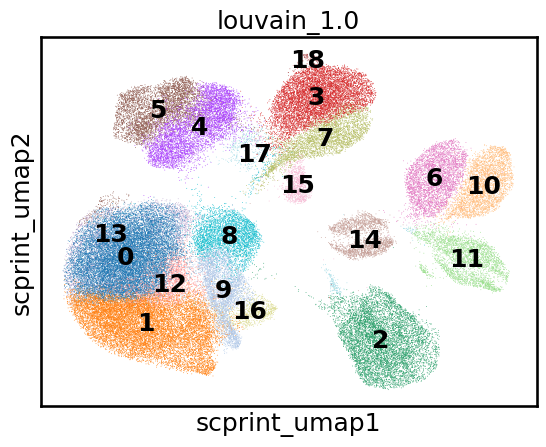

In [20]:
# check clusters
sc.pl.embedding(prostate_adata, basis="scprint_umap", color='louvain_1.0', show=False, legend_loc="on data")

In [21]:
# check cluster 9
i=9
loc = prostate_adata.obs['louvain_1.0']==str(i)
prostate_adata.obs[loc].conv_pred_disease_ontology_term_id.value_counts().head(2), prostate_adata.obs[loc].conv_pred_cell_type_ontology_term_id.value_counts().head(5)

(conv_pred_disease_ontology_term_id
 benign prostatic hyperplasia    3554
 normal                            18
 Name: count, dtype: int64,
 conv_pred_cell_type_ontology_term_id
 urethra urothelial cell                    1703
 luminal cell of prostate epithelium         703
 mucous neck cell                            566
 basal epithelial cell of prostatic duct     372
 club cell                                   174
 Name: count, dtype: int64)

In [6]:
# check cluster 11
i=11
loc = prostate_adata.obs['louvain_1.0']==str(i)
prostate_adata.obs[loc].cleaned_pred_disease_ontology_term_id.value_counts().head(2), prostate_adata.obs[loc].cleaned_pred_cell_type_ontology_term_id.value_counts().head(5)

(cleaned_pred_disease_ontology_term_id
 benign prostatic hyperplasia    2930
 normal                            68
 Name: count, dtype: int64,
 cleaned_pred_cell_type_ontology_term_id
 IgG-negative class switched memory B cell    2840
 other                                         142
 CD1c-positive myeloid dendritic cell            8
 basophil                                        7
 CD4-positive, alpha-beta thymocyte              5
 Name: count, dtype: int64)

In [7]:
# We have find a nice IgG-negative class switched memory B cell cluster. let's use it and define a clean annotation for a plot
loc = loc&(prostate_adata.obs.cleaned_pred_cell_type_ontology_term_id=="IgG-negative class switched memory B cell")
prostate_adata.obs[loc].cleaned_pred_disease_ontology_term_id.value_counts().head(2)

cleaned_pred_disease_ontology_term_id
benign prostatic hyperplasia    2771
normal                            60
Name: count, dtype: int64

In [8]:
# making a "focus" annotation for the B-cell to generate a nice plot of the B-cell cluster only
prostate_adata.obs['focus'] = "other"
prostate_adata.obs.loc[loc, 'focus'] = "memory B cell"
prostate_adata.obs.loc[loc & (prostate_adata.obs['cleaned_pred_disease_ontology_term_id']=='benign prostatic hyperplasia'), 'focus'] = "BPH associated memory B cell"
prostate_adata.obs['focus'].value_counts()

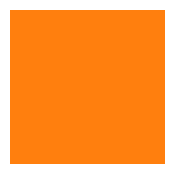

In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import seaborn as sns
color = sns.color_palette()[1]
fig, ax = plt.subplots(figsize=(2, 2))
rect = patches.Rectangle((0, 0), 1, 1, facecolor=color)
ax.add_patch(rect)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')
plt.show()

... storing 'focus' as categorical
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


<Axes: title={'center': 'focus'}, xlabel='scprint_umap_rot1', ylabel='scprint_umap_rot2'>

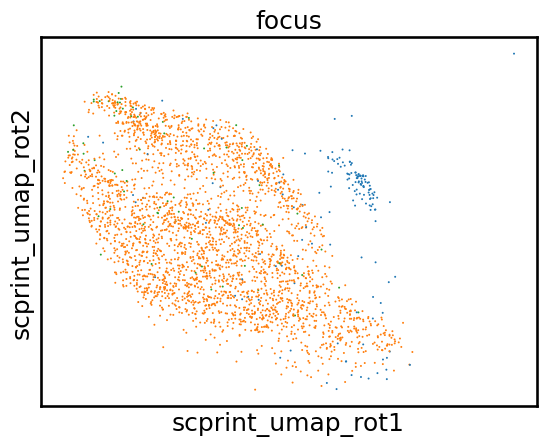

In [32]:
# looking at the B-cell cluster. We can see some normal and BPH-associated memory B-cells
sc.pl.embedding(prostate_adata[(prostate_adata.obs['louvain_1.0']==str(i)) & (prostate_adata.obsm['scprint_umap'][:,0]>4)], basis="scprint_umap",color='focus', show=False, size=8, title="Switched memory B-cell cluster", legend_loc="right margin")

In [ ]:
# here we use a function of scdataloader to add some more gene annotations to our dataset so we can view HGNC symbols
genedf = utils.load_genes(prostate_adata.obs.organism_ontology_term_id.iloc[0])
# columns that create issues when saving anndatas
prostate_adata.var = genedf.loc[prostate_adata.var.index].drop(columns=["stable_id", "created_at", "updated_at"])

... storing 'focus' as categorical
... storing 'symbol' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'description' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


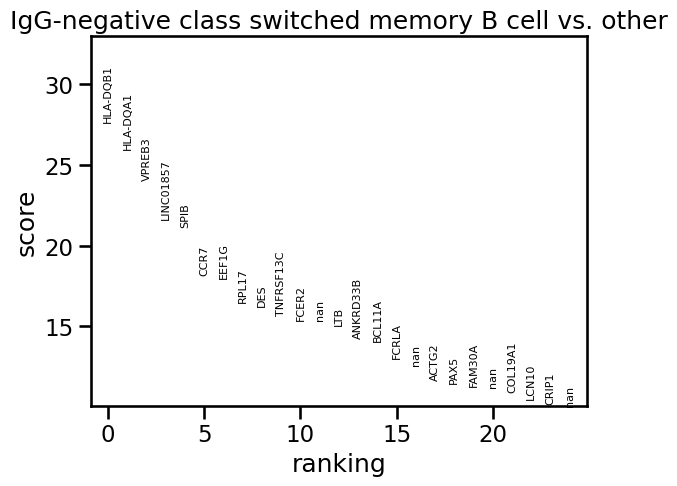

In [ ]:
# now the diff expression between B-cells and the rest
sc.tl.rank_genes_groups(prostate_adata, groupby='cleaned_pred_cell_type_ontology_term_id', groups=['IgG-negative class switched memory B cell'], reference='other', method='t-test')
# Plot the most differentially expressed genes
sc.pl.rank_genes_groups(prostate_adata, n_genes=25, sharey=False, gene_symbols='symbol')
# super strong B cell markers

## Denoising and differential expression

What we found out from our previous analysis is that there is not a lot of normal (i.e. healthy) B-cells in our cluster, most of them are BPH associated. In this case, if we wanted to compare BPH B-cells to normal B-cells we might be very underpowered...

Instead of going to look for some other dataset, let's use `scPRINT` to increase the depth of the expression profile of the cells, virtually adding more signal to our dataset.

We will use the `Denoiser` class (see more about the class in our [documentation](https://www.jkobject.com/scPrint/)) in a similar way `Trainer` is used in pytorch lightning to denoise the expression profile of the cells.

We will then show the results of differential expression analysis before and after denoising.

In [ ]:
# in case you started from here
prostate_adata = sc.read_h5ad("../data/prostate_adata_o2uniqsx.h5ad")
prostate_adata

AnnData object with n_obs × n_vars = 99826 × 70116
    obs: 'assay_ontology_term_id', 'donor_id', 'sex_ontology_term_id', 'disease_ontology_term_id', 'organism_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'init_dataset', 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology

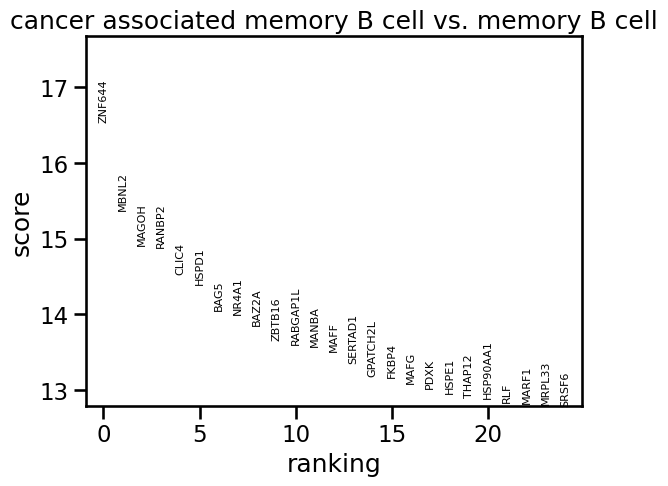

In [16]:
# here we compare memory B-cell in BPH to normal memory B cells before denoising
sc.tl.rank_genes_groups(prostate_adata, groupby='focus', groups=['BPH associated memory B cell'], reference='memory B cell', method='t-test')
# Plot the most differentially expressed genes
sc.pl.rank_genes_groups(prostate_adata, n_genes=25, sharey=False, gene_symbols='symbol')
# super strong B cell markers

In [19]:
# perform denoising
denoise = Denoiser( 
                    # could be on top differentially expressed genes or on random expressed genes in the cell (completed by random non expressed gene)
                    how="random expr"
                    # the size of the minibatch (need to fit in memory)
                    batch_size=20, 
                    # the number of genes to use
                    max_len=5000, 
                    # the number of cells to use (here more than what we will use so we will use everything)
                    max_cells=10_000, 
                    doplot=False, 
                    # how much do we want to increase the depth / counts of the cells (here, 10x)
                    predict_depth_mult=10, 
                    )
idx, genes, expr = denoise(model, prostate_adata[prostate_adata.obs['focus']!="other"])

100%|██████████| 82/82 [00:50<00:00,  1.64it/s]


In [20]:
# now what we are doing here it to complete the expression profile with the denoised values. this is not done by default for now
i = 0
prostate_adata.X = prostate_adata.X.tolil()
for idx, val in enumerate(prostate_adata.obs['focus']!="other"):
    if val:
        prostate_adata.X[idx, prostate_adata.var.index.get_indexer(np.array(model.genes)[genes[i]])] = expr[i]
        i += 1
prostate_adata.X = prostate_adata.X.tocsr()

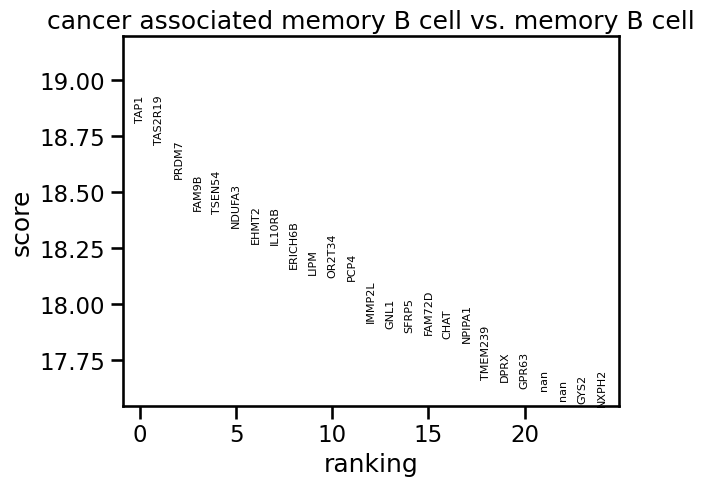

In [21]:
# now we compare memory B-cell in BPH to normal memory B cells after denoising
sc.tl.rank_genes_groups(prostate_adata, groupby='focus', groups=['BPH associated memory B cell'], reference='memory B cell', method='t-test')
# Plot the most differentially expressed genes
sc.pl.rank_genes_groups(prostate_adata, n_genes=25, sharey=False, gene_symbols='symbol')
# super strong B cell markers

In [9]:
prostate_adata.write_h5ad("../../data/prostate_adata_denoised.h5ad")

In [3]:
prostate_adata = sc.read_h5ad("../../data/prostate_adata_denoised.h5ad")

## Gene network inference

Finally we will use scPRINT to infer gene networks on another cell of interest, the fibroblasts, in both normal and BPH conditions.

We will  use the `GRNfer` class to infer gene networks. (_see the [cancer_usecase_part2.ipynb](./cancer_usecase_part2.ipynb) for more details on how to analyse the gene networks._)

In [38]:
prostate_adata.obs.cleaned_pred_cell_type_ontology_term_id.value_counts().head(20)

cleaned_pred_cell_type_ontology_term_id
basal epithelial cell of prostatic duct                             25740
prostate gland microvascular endothelial cell                       12165
urethra urothelial cell                                             10952
CD1c-positive myeloid dendritic cell                                 6898
other                                                                5869
aortic smooth muscle cell                                            3970
effector CD8-positive, alpha-beta T cell                             3925
pancreatic acinar cell                                               3711
luminal cell of prostate epithelium                                  3435
fibroblast of connective tissue of nonglandular part of prostate     3334
mucous neck cell                                                     3260
IgG-negative class switched memory B cell                            2932
basophil                                                             186

In [33]:
loc = (prostate_adata.obs.cleaned_pred_cell_type_ontology_term_id=="fibroblast of connective tissue of glandular part of prostate")
prostate_adata.obs[loc]['cleaned_pred_disease_ontology_term_id'].value_counts()

cleaned_pred_disease_ontology_term_id
benign prostatic hyperplasia    1482
normal                           673
other                              4
Name: count, dtype: int64

In [52]:
prostate_adata.obs[loc]['louvain_1.0'].value_counts().head(10)

louvain_1.0
5     1458
4      671
17      10
8        8
7        7
0        3
9        2
6        0
3        0
1        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
2        0
18       0
Name: count, dtype: int64

In [34]:
loc = loc & (prostate_adata.obs['louvain_1.0']==str(5))
prostate_adata.obs[loc]['cleaned_pred_disease_ontology_term_id'].value_counts()

cleaned_pred_disease_ontology_term_id
benign prostatic hyperplasia    790
normal                          664
other                             4
Name: count, dtype: int64

In [35]:
prostate_adata.obs['fibro'] = None
prostate_adata.obs.loc[loc, 'fibro']="fibroblasts"
prostate_adata.obs.loc[loc & (prostate_adata.obs.cleaned_pred_disease_ontology_term_id=="benign prostatic hyperplasia"), 'fibro']="BPH associated fibroblasts"

... storing 'focus' as categorical
... storing 'fibro' as categorical
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


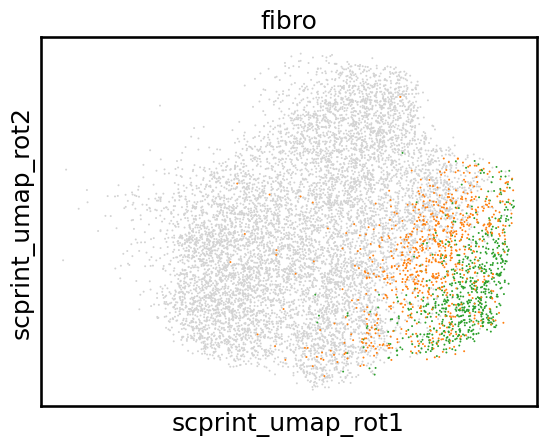

In [37]:
sc.pl.embedding(prostate_adata[prostate_adata.obs['louvain_1.0'].isin(["5","4"]) & (prostate_adata.obsm['scprint_umap'][:,1]>10)], basis="scprint_umap_rot",color='fibro', show=False, size=8, title="Fibroblasts cluster", legend_loc="right margin")

In [8]:
grn_inferer = GNInfer(
                    # here we use the most variable genes across the fibroblasts vs the rest
                    how="most var across",
                    #how="random expr",
                    # we will preprocess the attention matrix with softmax
                    preprocess="softmax",
                    # we don't aggregate the heads here, we will do it manually
                    head_agg='none',
                    # here if we generate the attention matrices by performing a task, like denoising or by just passing the expression profile through the model
                    forward_mode="none",
                    # the number of genes to use (here the 4000 most variable genes)
                    num_genes=4000,
                    # the max number of cell to use per cell type
                    max_cells=300,
                    doplot=False,
                    batch_size=16,
                    # the column in anndata the defines the cell type
                    cell_type_col='fibro',
                    # list of layers to use
                    layer=list(range(model.nlayers))[:]
                    )

In [9]:
# I was missing this from the model (not really necessary)
model.organisms = ['NCBITaxon:9606', 'NCBITaxon:10090']
prostate_adata.obs.fibro = prostate_adata.obs.fibro.astype(str)
prostate_adata.obs[prostate_adata.obs.fibro=="BPH associated fibroblasts"].disease.value_counts()

In [ ]:
# compute GRNs on fibroblasts, we use all the atetetion layers
grn = grn_inferer(model, prostate_adata, cell_type="fibroblasts")
# highlight differential links on genes that are expressed in both 
grn.varp['all'] = grn.varp['GRN'].copy()
# now we aggregate the heads by taking their average
grn.varp['GRN'] = grn.varp['GRN'].mean(-1)
grn.write_h5ad("../../data/prostate_fibro_grn_all.h5ad")

In [11]:
#same on the BPH associated fibroblasts
# I wanted to use only the ones that the labellers had defined as coing from BPH
prostate_adata.obs.loc[(prostate_adata.obs.fibro=="BPH associated fibroblasts") & ( prostate_adata.obs.disease=="benign prostatic hyperplasia"), 'fibro'] = "true BPH associated fibroblasts"

grn_c = grn_inferer(model, prostate_adata, cell_type="true cancer associated fibroblasts")
# highlight differential links on genes that are expressed in both
grn_c.varp['all'] = grn_c.varp['GRN'].copy()
grn_c.varp['GRN'] = grn_c.varp['GRN'].mean(-1)
grn_c.write_h5ad("../../data/prostate_BPH_fibro_grn_all.h5ad")